## Práctica: Autoencoder para Eliminar Ruido en Imágenes
Objetivo: Entrenar un autoencoder convolucional para eliminar ruido Gaussiano de imágenes del dataset CIFAR-10.

## 1. Configuración Inicial

In [17]:
# Instalación de bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

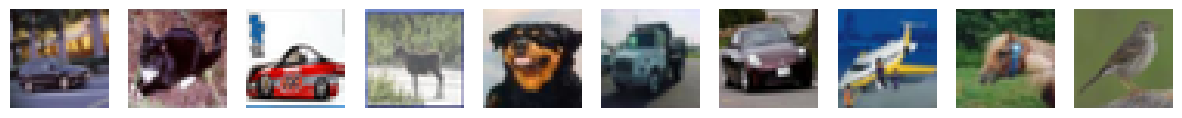

Forma del conjunto de entrenamiento: (50000, 32, 32, 3)


In [18]:
# Cargar el dataset CIFAR-10
(x_train, _), (x_test, _) = cifar10.load_data()

# Visualizar 10 ejemplos aleatorios
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    idx = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[idx])
    axes[i].axis('off')
plt.show()

# Verificar dimensiones
print("Forma del conjunto de entrenamiento:", x_train.shape)


## 2. Preparación de Datos

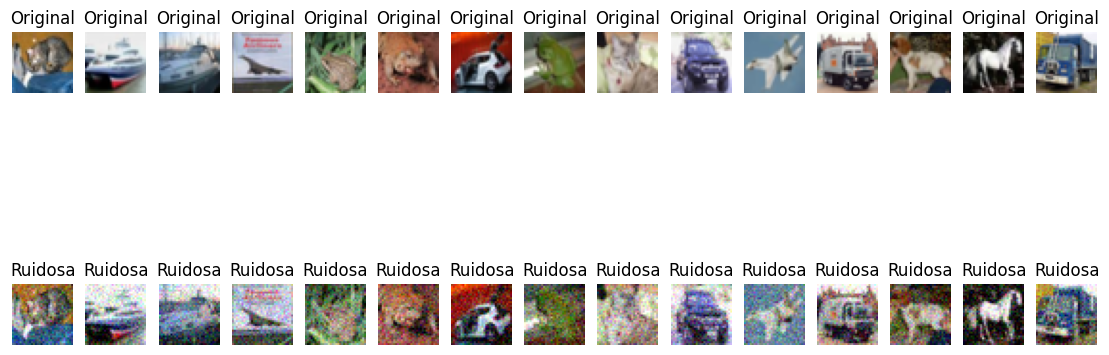

In [19]:
# Normalización
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Añadir ruido Gaussiano
def add_noise(images, noise_factor=0.1):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Visualizar imágenes con ruido
n = 15
plt.figure(figsize=(14, 6))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Ruidosa")
    plt.axis("off")
plt.show()


## 3. Diseño de la Arquitectura

In [20]:
def build_autoencoder():
    input_img = layers.Input(shape=(32, 32, 3))

     # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(0.3)(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(encoded)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del Modelo

In [13]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

# Callbacks
checkpoint = ModelCheckpoint("best_autoencoder.h5", save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[checkpoint, early_stop]
)


Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0243

391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 0.0242 - val_loss: 0.0220
Epoch 2/30
389/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0065 - val_loss: 0.0180
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0057 - val_loss: 0.0169
Epoch 4/30
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0053 - val_loss: 0.0158
Epoch 5/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0050 - val_loss: 0.0152
Epoch 6/30
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0049 - val_loss: 0.0147
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0047 - val_loss: 0.0142
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0046 - val_loss: 0.0151
Epoch 9/30
387/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0045 - val_loss: 0.0135
Epoch 10/30
390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0045 - val_loss: 0.0134
Epoch 11/30
388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044

391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0044 - val_loss: 0.0131
Epoch 12/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0044 - val_loss: 0.0135
Epoch 13/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0043 - val_loss: 0.0134
Epoch 14/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0043 - val_loss: 0.0133
Epoch 15/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0043 - val_loss: 0.0137
Epoch 16/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0042 - val_loss: 0.0141


## 5. Evaluación y Visualización

In [14]:
# PSNR
def psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    return 10 * np.log10(1.0 / (mse + 1e-8))

decoded_imgs = autoencoder.predict(x_test_noisy)
avg_psnr = np.mean([psnr(x_test[i], decoded_imgs[i]) for i in range(len(x_test))])
print("PSNR promedio en test:", avg_psnr)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
PSNR promedio en test: 19.36711


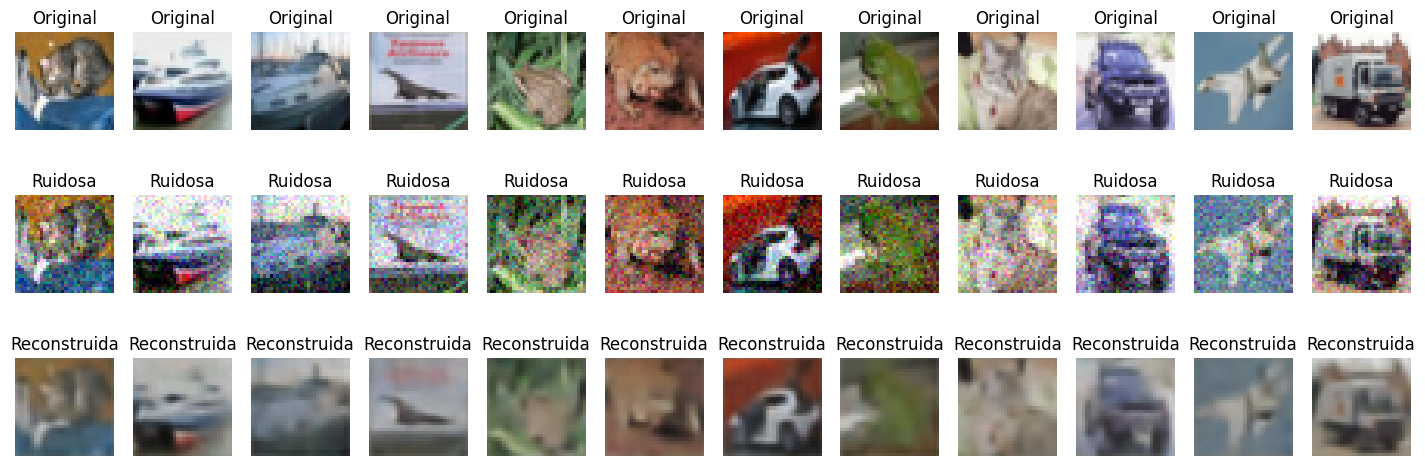

In [21]:
# Visualización de resultados
n = 12
plt.figure(figsize=(18, 6))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Ruidosa
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Ruidosa")
    plt.axis("off")

    # Reconstruida
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstruida")
    plt.axis("off")
plt.show()


## 6. Gráfico de la pérdida durante el entrenamiento

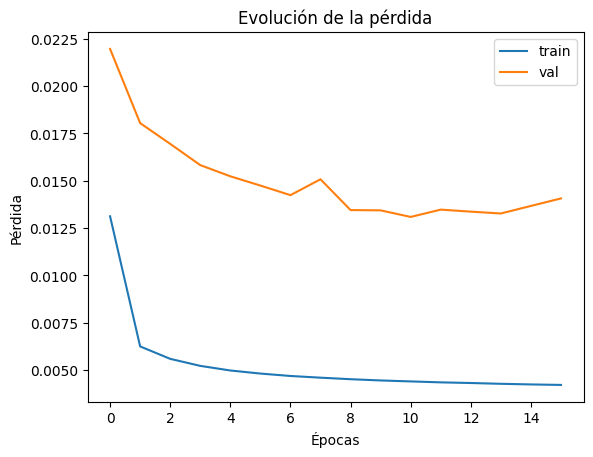

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida')
plt.legend()
plt.show()
